# Fit Stimler et al. leaf carbonyl sulfide flux data

Wu Sun

* Created: 2021-04-07
* Updated: 2022-02-08
* Adapted for release on 2022-02-23

## Import packages

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.ticker import MultipleLocator
from scipy import optimize, stats

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import lru_eqn
from config import dirs
from sat_vap import p_sat_h2o

In [3]:
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
# enforce TrueType fonts instead of Type 3 fonts
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

## Define functions

In [4]:
def lossfun_rel_uptake_wrapped(params, assim, rh, co2, obs):
    """Wrapped loss function for fitting parameters in the LRU equation."""
    return lru_eqn.lossfun_rel_uptake(params[0], params[1], assim, rh, co2, obs)

## Read data

Units

* `pressure`: Pa
* `r_bw`: m<sup>2</sup> s mol<sup>–1</sup>
* `co2_a`: μmol mol<sup>–1</sup>
* `ppfd`: μmol m<sup>–2</sup> s<sup>–1</sup>
* `T_leaf`: °C
* `e_a`: Pa
* `co2_i`: μmol mol<sup>–1</sup>
* `g_sw`: mol m<sup>–2</sup> s<sup>–1</sup>
* `transpiration`: mol m<sup>–2</sup> s<sup>–1</sup>
* `cos_assim`: pmol m<sup>–2</sup> s<sup>–1</sup>
* `cos_a`: pmol mol<sup>–1</sup>
* `vmax`: μmol m<sup>–2</sup> s<sup>–1</sup>
* `is_c4`: boolean; 0 for C<sub>3</sub> and 1 for C<sub>4</sub>

In [5]:
df = pd.read_csv(
    f"{dirs.data}/stimler-light-and-ci-subset.csv", engine="c", skiprows=[1]
)

In [6]:
df.head()

dataset_name  dataset_id        date              species  pressure  \
0  amaranthus-light           1  2008-07-09  Amaranthus cruentus     99867   
1  amaranthus-light           1  2008-07-09  Amaranthus cruentus     99867   
2  amaranthus-light           1  2008-07-09  Amaranthus cruentus     99865   
3  amaranthus-light           1  2008-07-09  Amaranthus cruentus     99865   
4  amaranthus-light           1  2008-07-09  Amaranthus cruentus     99867   

    r_bw   co2_a  ppfd  T_leaf     e_a   co2_i  co2_assim      g_sw  \
0  0.615  468.04    55    21.5  1266.6  380.28       0.74  0.015223   
1  0.615  468.04    55    21.5  1266.6  380.28       0.74  0.015223   
2  0.615  450.91    91    21.6  1412.9  338.98       1.41  0.021936   
3  0.615  450.91    91    21.6  1412.9  338.98       1.41  0.021936   
4  0.615  400.61   179    21.9  1684.5  251.50       3.42  0.038772   

   transpiration  cos_assim   cos_a   vmax  is_c4  
0       0.000202       2.48  964.92  28.02      1  
1       0.000202       5.69  886.21  28.02      1  
2       0.000262       6.27  871.38  28.02      1  
3       0.000262       9.11  801.40  28.02      1  
4       0.000375       9.69  786.74  28.02      1

## Calculate other gas-exchange quantities

* `cos_s`: COS concentration at the leaf surface (pmol m<sup>–2</sup> s<sup>–1</sup>)
* `co2_s`: CO<sub>2</sub> concentration at the leaf surface (μmol m<sup>–2</sup> s<sup>–1</sup>)
* `e_s`: water vapor pressure at the leaf surface (Pa)
* `e_sat`: saturation water vapor pressure at the leaf surface (Pa)
* `h_s`: relative humidity at the leaf surface
* `bb_fac`: the Ball–Berry factor, _A·h_<sub>s</sub>/_C_<sub>s</sub>
* `lru`: leaf relative uptake ratio (dimensionless)

In [7]:
df["cos_s"] = df["cos_a"] - df["cos_assim"] * df["r_bw"] * lru_eqn.RATIO_GB_H2O_COS
df["co2_s"] = df["co2_a"] - df["co2_assim"] * df["r_bw"] * lru_eqn.RATIO_GB_H2O_CO2
df["e_s"] = df["e_a"] + df["transpiration"] * df["r_bw"] * df["pressure"]
df["e_sat"] = p_sat_h2o(df["T_leaf"])
df["h_s"] = df["e_s"] / df["e_sat"]
# cap h_s at 1.0
df.loc[df["h_s"] > 1.0, "h_s"] = 1.0
df["bb_fac"] = df["co2_assim"] * df["h_s"] / df["co2_s"]
df["lru"] = df["cos_assim"] * df["co2_s"] / (df["co2_assim"] * df["cos_s"])
# lru is only defined when both COS and CO2 are taken up
df.loc[(df["co2_assim"] < 0) | (df["cos_assim"] < 0), "lru"] = np.nan

## Diagnostic plots

In [8]:
dataset_names = df["dataset_name"].unique()

for i, name in enumerate(dataset_names):
    print(i, name)

dataset_names_light = [name for name in dataset_names if "light" in name]
dataset_names_co2 = [name for name in dataset_names if "Ci" in name]

0 amaranthus-light
1 corn-light
2 hibiscus-light
3 sage-light-a
4 sage-light-b
5 sage-light-c
6 sage-light-d
7 sage-light-e
8 sorghum-light
9 sage-Ci-a
10 sage-Ci-b
11 sage-Ci-c


### Figure S1: LRU vs. PAR for each individual plant (light-varying experiments only)

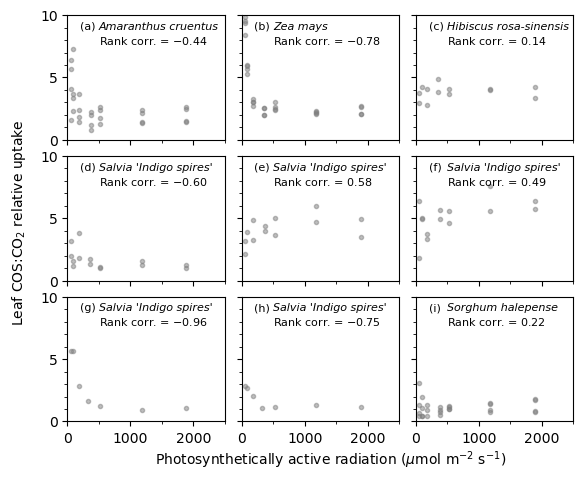

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(6, 4.8), sharex=True, sharey=True)
for i, name in enumerate(dataset_names_light):
    ax = axes[i // 3, i % 3]
    _df_subset = df[df["dataset_name"] == name]
    ax.plot(
        _df_subset["ppfd"], _df_subset["lru"], ".", color="tab:gray", alpha=0.5,
    )

    species_name = _df_subset["species"].unique()[0]
    rho = stats.spearmanr(_df_subset["ppfd"], _df_subset["lru"])[0]

    ax.text(
        0.08,
        0.87,
        f"({chr(i + 97)})",
        fontsize=8,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )
    ax.text(
        0.20,
        0.87,
        species_name,
        fontsize=8,
        fontstyle="italic",
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )
    ax.text(
        0.20,
        0.75,
        "Rank corr. = $%.2f$" % rho,
        fontsize=8,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )

axes[0, 0].set_xlim((0, 2500))
axes[0, 0].xaxis.set_major_locator(MultipleLocator(1000))
axes[0, 0].xaxis.set_minor_locator(MultipleLocator(500))
axes[0, 0].set_ylim((0, 10))
axes[0, 0].yaxis.set_major_locator(MultipleLocator(5))
axes[0, 0].yaxis.set_minor_locator(MultipleLocator(1))

fig.tight_layout(rect=(0.04, 0.03, 1.0, 1.0), w_pad=0.1, h_pad=0.15)
fig.text(
    0.03,
    0.525,
    "Leaf COS:CO$_2$ relative uptake",
    rotation=90,
    ha="center",
    va="center",
)
fig.text(
    0.55,
    0.03,
    "Photosynthetically active radiation ($\\mu$mol m$^{-2}$ s$^{-1}$)",
    ha="center",
    va="center",
)

fig.savefig(f"{dirs.plots}/stimler-lru-vs-ppfd.pdf")
del fig, axes, ax

## Estimate the Ball–Berry parameters

In [10]:
df_est = pd.DataFrame(
    {
        "dataset_id": df["dataset_id"].unique(),
        "dataset_name": "",
        "n_obs": -1,
        "vmax": np.nan,
        "cv_bb_fac": np.nan,
        "m": np.nan,
        "se_m": np.nan,
        "g_0": np.nan,
        "se_g_0": np.nan,
        "r2_bb_fit": np.nan,
    }
)

In [11]:
for i, dataset_id in enumerate(df_est["dataset_id"]):
    _df_subset = df[df["dataset_id"] == dataset_id]
    df_est.loc[i, "dataset_name"] = _df_subset["dataset_name"].values[0]
    df_est.loc[i, "vmax"] = _df_subset["vmax"].values[0]
    x = _df_subset["bb_fac"]
    df_est.loc[i, "cv_bb_fac"] = np.nanstd(x, ddof=1) / np.nanmean(x)
    x = sm.add_constant(x)
    y = _df_subset["g_sw"]
    model = sm.RLM(y, x)
    fit = model.fit()
    df_est.loc[i, "n_obs"] = fit.nobs
    df_est.loc[i, "g_0"], df_est.loc[i, "m"] = fit.params
    df_est.loc[i, "se_g_0"], df_est.loc[i, "se_m"] = fit.bse
    pred = fit.predict()
    df_est.loc[i, "r2_bb_fit"] = stats.pearsonr(y.values, pred)[0] ** 2

Criteria for discarding a bad fit

* number of observations <= 4
* fitted _m_ is negative
* _R_<sup>2</sup> of the Ball–Berry fit < 0.25    

In [12]:
df_est = df_est.loc[
    (df_est["n_obs"] > 4) & (df_est["m"] > 0) & (df_est["r2_bb_fit"] > 0.25)
].reset_index(drop=True)

In [13]:
df_est

dataset_id      dataset_name  n_obs    vmax  cv_bb_fac          m  \
0            1  amaranthus-light     28   28.02   0.866982   6.915820   
1            2        corn-light     28   43.87   1.010747   8.401009   
2            3    hibiscus-light     13   61.00   0.518343   8.016997   
3            4      sage-light-a     14   79.30   0.627183   3.228871   
4            5      sage-light-b     13   27.29   0.418691  18.277487   
5            6      sage-light-c     14   26.80   0.462234  23.609366   
6            7      sage-light-d      7   72.10   0.806687   4.365574   
7            8      sage-light-e      7  106.10   0.825128   3.221302   
8            9     sorghum-light     27   25.28   0.840889   6.786565   
9           10         sage-Ci-a     14   49.70   0.254135  10.587148   
10          11         sage-Ci-b     14  101.00   0.398797   7.116051   
11          12         sage-Ci-c     20  101.40   0.310274  16.208594   

        se_m       g_0    se_g_0  r2_bb_fit  
0   0.322617  0.003157  0.008140   0.946450  
1   0.357871  0.007195  0.017088   0.764560  
2   1.515379  0.014780  0.022202   0.876736  
3   0.250175  0.074061  0.011359   0.933893  
4   4.219929 -0.042429  0.046871   0.789492  
5   3.929742 -0.025460  0.036005   0.766694  
6   0.327518  0.033170  0.008646   0.968368  
7   0.221093  0.015632  0.005190   0.971241  
8   0.287780 -0.006696  0.007677   0.841123  
9   4.554093  0.113164  0.125477   0.310522  
10  0.529862  0.147066  0.022758   0.937619  
11  2.927728  0.207556  0.081438   0.630010

### Figure: Ball–Berry curve fitting of _g_<sub>sw</sub> [not used]

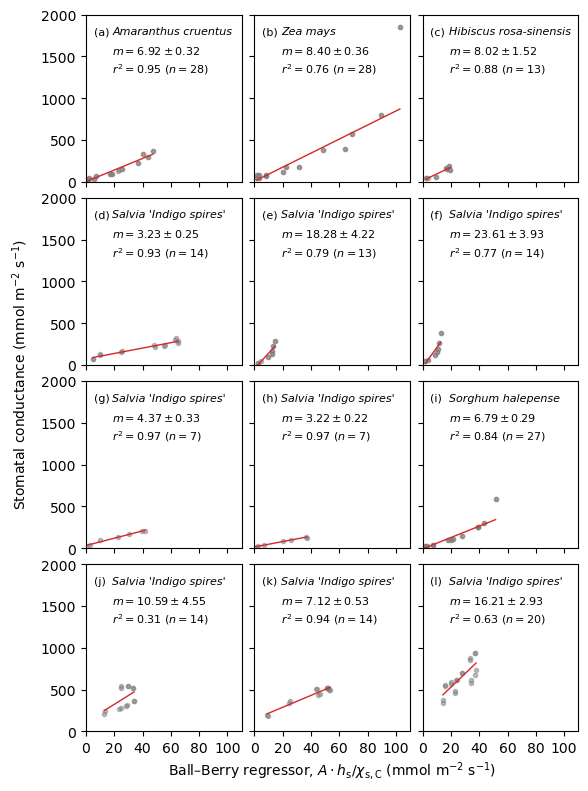

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(6, 8), sharex=True, sharey=True)
for i, name in enumerate(dataset_names):
    ax = axes[i // 3, i % 3]
    _df_subset = df[df["dataset_name"] == name]
    x = _df_subset["bb_fac"].values * 1e3
    y = _df_subset["g_sw"].values * 1e3
    ax.plot(x, y, ".", color="tab:gray", alpha=0.5)

    n_obs, m, se_m, g_0, se_g_0, r2_bb_fit = df_est.loc[
        df_est["dataset_name"] == name,
        ["n_obs", "m", "se_m", "g_0", "se_g_0", "r2_bb_fit"],
    ].values[0]
    x_pred = np.array([x.min(), x.max()])
    y_pred = m * x_pred + g_0 * 1e3
    ax.plot(x_pred, y_pred, "-", color="tab:red", lw=1)

    species_name = _df_subset["species"].unique()[0]
    ax.text(
        0.05,
        0.87,
        f"({chr(i + 97)})",
        fontsize=8,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )
    ax.text(
        0.17,
        0.87,
        species_name,
        fontsize=8,
        fontstyle="italic",
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )
    ax.text(
        0.17,
        0.75,
        "$m = %.2f \\pm %.2f$" % (m, se_m),
        fontsize=8,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )
    ax.text(
        0.17,
        0.63,
        "$r^2 = %.2f$ ($n = %i$)" % (r2_bb_fit, n_obs),
        fontsize=8,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )

axes[0, 0].set_xlim((0, 110))
axes[0, 0].xaxis.set_major_locator(MultipleLocator(20))
axes[0, 0].set_ylim((0, 2000))
axes[0, 0].yaxis.set_major_locator(MultipleLocator(500))

fig.tight_layout(rect=(0.04, 0.03, 1.0, 1.0), w_pad=0.1, h_pad=0.15)
fig.text(
    0.03,
    0.525,
    "Stomatal conductance (mmol m$^{-2}$ s$^{-1}$)",
    rotation=90,
    ha="center",
    va="center",
)
fig.text(
    0.55,
    0.03,
    "Ball–Berry regressor, $A\\cdot h_\\mathrm{s} / \\chi_\\mathrm{s,C}$ (mmol m$^{-2}$ s$^{-1}$)",
    ha="center",
    va="center",
)
del fig, axes, ax

## Estimate the internal conductance to COS

The internal resistance to COS can be calculated following

$$\dfrac{1}{g_\mathrm{i,S}} = \dfrac{\chi_\mathrm{a,S}}{A_\mathrm{S}} - \dfrac{1}{g_\mathrm{b,S}} - \dfrac{1}{g_\mathrm{s,S}}$$

$$g_\mathrm{i,S} = \dfrac{1}{\dfrac{\chi_\mathrm{a,S}}{A_\mathrm{S}} - \dfrac{1}{g_\mathrm{b,S}} - \dfrac{1}{g_\mathrm{s,S}}}$$

$$g_\mathrm{i,S} = \dfrac{1}{\dfrac{\chi_\mathrm{a,S}}{A_\mathrm{S}} - \dfrac{R_\text{W–S}^{2/3}}{g_\mathrm{b,W}} - \dfrac{R_\text{W–S}}{g_\mathrm{s,W}}}$$


In [15]:
df["g_is"] = 1.0 / (
    df["cos_a"] / df["cos_assim"]
    - lru_eqn.RATIO_GB_H2O_COS * df["r_bw"]
    - lru_eqn.RATIO_GS_H2O_COS / df["g_sw"]
)

Calculate the average $g_\mathrm{i,S}$ under high light (PAR > 1000 μmol m<sup>–2</sup> s<sup>–1</sup>).

In [16]:
for i, dataset_id in enumerate(df_est["dataset_id"]):
    _g_is_high_light = df.loc[
        (df["dataset_id"] == dataset_id) & (df["ppfd"] > 1e3), "g_is",
    ].values
    df_est.loc[i, "g_is"] = np.nanmean(_g_is_high_light)
    if len(_g_is_high_light) > 1:
        df_est.loc[i, "sem_g_is"] = stats.sem(_g_is_high_light)
    else:
        df_est.loc[i, "sem_g_is"] = np.nan

## Estimate the Ball–Berry slope and internal conductance to COS from the LRU equation

The general LRU equation is

$$\mathrm{LRU} = \dfrac{1}{\dfrac{R_\text{W-S}}{m\cdot h_\mathrm{s}} + \dfrac{A}{g_\mathrm{i,S}\cdot\chi_\mathrm{s,C}}}$$

The general LRU equation can be rearranged as:

$$ \dfrac{1}{\mathrm{LRU}} = \dfrac{1}{m}\cdot\dfrac{R_\text{W-S}}{h_\mathrm{s}} + \dfrac{1}{g_\mathrm{i,S}}\cdot\dfrac{A}{\chi_\mathrm{s,C}}$$

The parameters $1/m$ and $1/g_\mathrm{i,S}$ can be estimated using multivariate linear regression. The weights are

$$ w = \mathrm{LRU}^2\cdot A_\mathrm{C}$$

so that the cost function is the sum of squares of CO<sub>2</sub> assimilation-weighted LRU.

Update on 2021-10-05: If the regression fits a negative $m$ value, revert to constrained optimization.

In [17]:
params_init = np.array([9.0, 0.1])  # m [dimensionless]  # g_is [mol m^-2 s^-1]
params_bounds = [
    (0.1, 100.0),  # m [dimensionless]
    (1e-3, 10.0),  # g_is [mol m^-2 s^-1]
]

In [18]:
df_est["n_obs_lru"] = -1
for i, dataset_id in enumerate(df_est["dataset_id"]):
    _df_subset = df[df["dataset_id"] == dataset_id]
    y = 1.0 / _df_subset["lru"]
    x1 = (lru_eqn.RATIO_GS_H2O_COS / _df_subset["h_s"]).rename("x1")
    x2 = (_df_subset["co2_assim"] / _df_subset["co2_s"]).rename("x2")
    X = pd.concat([x1, x2], axis=1)
    weights = _df_subset["lru"].values ** 2 * _df_subset["co2_assim"].values
    # note: no constant term
    model = sm.WLS(y, X, weights)
    fit = model.fit()

    # if m is positive, save the results; else use optimization to refit m
    if fit.params[0] > 0:
        df_est.loc[i, "fit_method"] = "WLS"
        df_est.loc[i, "n_obs_lru"] = np.sum(np.isfinite(y))
        df_est.loc[i, "m_lru"] = 1.0 / fit.params[0]
        df_est.loc[i, "se_m_lru"] = np.abs(
            df_est.loc[i, "m_lru"] * np.abs(fit.bse[0] / fit.params[0])
        )
        df_est.loc[i, "g_is_lru"] = 1.0 / fit.params[1]
        df_est.loc[i, "se_g_is_lru"] = np.abs(
            df_est.loc[i, "g_is_lru"] * np.abs(fit.bse[1] / fit.params[1])
        )
        df_est.loc[i, "r2_lru_fit"] = fit.rsquared
        # _lru_pred = 1.0 / (X.values @ fit.params.values)
        # df_est.loc[i, "r2_lru_fit"] = (
        #     stats.pearsonr(_df_subset["lru"].values, _lru_pred)[0] ** 2
        # )
    else:
        pass
        df_est.loc[i, "fit_method"] = "L-BFGS-B"
        res = optimize.minimize(
            lossfun_rel_uptake_wrapped,
            params_init,
            args=(
                _df_subset["co2_assim"].values,
                _df_subset["h_s"].values,
                _df_subset["co2_s"].values,
                _df_subset["lru"].values,
            ),
            method="L-BFGS-B",
            bounds=params_bounds,
            options={"disp": False},
        )
        df_est.loc[i, "n_obs_lru"] = np.sum(np.isfinite(y))
        df_est.loc[i, "m_lru"] = res.x[0]
        df_est.loc[i, "se_m_lru"] = np.nan
        df_est.loc[i, "g_is_lru"] = res.x[1]
        df_est.loc[i, "se_g_is_lru"] = np.nan
        _lru_pred = lru_eqn.rel_uptake(
            res.x[0],
            res.x[1],
            _df_subset["co2_assim"].values,
            _df_subset["h_s"].values,
            _df_subset["co2_s"].values,
        )
        df_est.loc[i, "r2_lru_fit"] = (
            stats.pearsonr(_df_subset["lru"].values, _lru_pred)[0] ** 2
        )

In [19]:
df_est["plot.symbol"] = ["d", "s", "v",] + ["o"] * 5 + ["^"] + ["o"] * 3
df_est["plot.is_filled"] = [True] * 9 + [False] * 3
df_est["plot.color"] = (
    [plt.cm.tab20b(14), plt.cm.tab20c(1), plt.cm.tab10(3),]
    + [plt.cm.tab20b(2)] * 5
    + [plt.cm.tab20b(9)]
    + [plt.cm.tab20b(2)] * 3
)
df_est["plot.short_legend_name"] = (
    ["amaranthus", "corn", "hibiscus",]
    + ["sage (PAR)"] * 5
    + ["sorghum"]
    + ["sage ($C_\\mathrm{i}$)"] * 3
)

### Figure 1: A combined figure comparing $m$ and $g_\mathrm{i,S}$ estimates

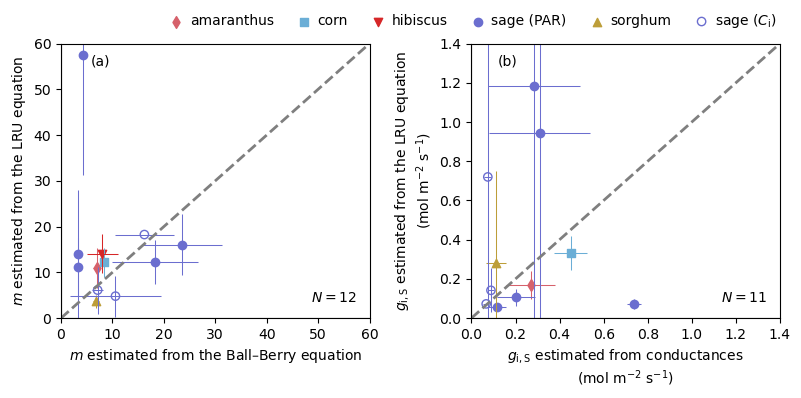

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, row in df_est.iterrows():
    label = row["plot.short_legend_name"]
    if row["plot.is_filled"]:
        axes[0].scatter(
            row["m"],
            row["m_lru"],
            marker=row["plot.symbol"],
            color=row["plot.color"],
            label=label,
        )
    else:
        axes[0].scatter(
            row["m"],
            row["m_lru"],
            marker=row["plot.symbol"],
            color=row["plot.color"],
            facecolor="none",
            label=label,
        )

    axes[0].errorbar(
        row["m"],
        row["m_lru"],
        xerr=row["se_m"] * 1.96,
        yerr=row["se_m_lru"] * 1.96,
        color=row["plot.color"],
        linewidth=0.75,
    )

    if row["g_is"] < 0:
        continue

    if row["plot.is_filled"]:
        axes[1].scatter(
            row["g_is"],
            row["g_is_lru"],
            marker=row["plot.symbol"],
            color=row["plot.color"],
            label=label,
        )
    else:
        axes[1].scatter(
            row["g_is"],
            row["g_is_lru"],
            marker=row["plot.symbol"],
            color=row["plot.color"],
            facecolor="none",
            label=label,
        )

    axes[1].errorbar(
        row["g_is"],
        row["g_is_lru"],
        xerr=row["sem_g_is"] * 1.96,
        yerr=row["se_g_is_lru"] * 1.96,
        color=row["plot.color"],
        linewidth=0.75,
    )

m_min = min(0, df_est["m"].min(), df_est["m_lru"].min())
m_max = max(60, df_est["m"].max(), df_est["m_lru"].max())
axes[0].plot([m_min, m_max], [m_min, m_max], "--", color="tab:gray", lw=2)
axes[0].axhline(0.0, color=plt.cm.tab20(15), lw=1, zorder=-2)
axes[0].axvline(0.0, color=plt.cm.tab20(15), lw=1, zorder=-2)
axes[0].set_xlim((m_min, m_max))
axes[0].set_ylim((m_min, m_max))
axes[0].set_xlabel("$m$ estimated from the Ball–Berry equation")
axes[0].set_ylabel("$m$ estimated from the LRU equation")
axes[0].text(0.095, 0.92, "(a)", fontsize=10, transform=axes[0].transAxes)
axes[0].text(0.81, 0.06, "$N = 12$", fontsize=10, transform=axes[0].transAxes)

g_is_min = max(0.0, min(df_est["g_is"].min(), df_est["g_is_lru"].min()))
g_is_max = max(1.4, df_est["g_is"].max(), df_est["g_is_lru"].max())
axes[1].plot([g_is_min, g_is_max], [g_is_min, g_is_max], "--", color="tab:gray", lw=2)
axes[1].axhline(0.0, color=plt.cm.tab20(15), lw=1, zorder=-2)
axes[1].axvline(0.0, color=plt.cm.tab20(15), lw=1, zorder=-2)
axes[1].set_xlim((g_is_min, g_is_max))
axes[1].set_ylim((g_is_min, g_is_max))
axes[1].set_xlabel(
    "$g_\\mathrm{i,S}$ estimated from conductances\n(mol m$^{-2}$ s$^{-1}$)"
)
axes[1].set_ylabel(
    "$g_\\mathrm{i,S}$ estimated from the LRU equation\n(mol m$^{-2}$ s$^{-1}$)"
)
axes[1].text(0.085, 0.92, "(b)", fontsize=10, transform=axes[1].transAxes)
axes[1].text(0.81, 0.06, "$N = 11$", fontsize=10, transform=axes[1].transAxes)

fig.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
handles, labels = axes[0].get_legend_handles_labels()
idx_subset = [0, 1, 2, 3, 8, 9]
handles_subset = [handles[i] for i in idx_subset]
labels_subset = [labels[i] for i in idx_subset]
lg = fig.legend(
    handles=handles_subset,
    labels=labels_subset,
    loc=(0.21, 0.91),
    ncol=6,
    handlelength=0.35,
    frameon=False,
)
fig.savefig(f"{dirs.plots}/stimler-m-and-gi.pdf")
del fig, axes